In [1]:
!ls

book_on_table.jpeg  molmo.ipynb  README.md  sam_molmo.py  test.jpg


In [ ]:
# huggingface login

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
The token `llama` has been saved to /voyager/projects/aditya/.huggingface_cache/stored_tokens
Your token has been saved to /voyager/projects/aditya/.huggingface_cache/token
Login successful.
The current active token is: `llama`


In [25]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import re
import cv2

from PIL import Image
from sam2.sam2_image_predictor import SAM2ImagePredictor
from transformers import (
    AutoModelForCausalLM,
    AutoProcessor,
    GenerationConfig,
    BitsAndBytesConfig
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
quant_config = BitsAndBytesConfig(load_in_4bit=True)
# Load SAM2 model.
predictor = SAM2ImagePredictor.from_pretrained('facebook/sam2.1-hiera-large')
# Load Molmo model.
processor = AutoProcessor.from_pretrained(
    'allenai/MolmoE-1B-0924', 
    trust_remote_code=True, 
    device_map='auto', 
    torch_dtype='auto'
)
model = AutoModelForCausalLM.from_pretrained(
    'allenai/MolmoE-1B-0924', 
    trust_remote_code=True, 
    offload_folder='offload', 
    quantization_config=quant_config, 
    torch_dtype='auto'
)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPTNeoXTokenizer'. 
The class this function is called from is 'GPT2TokenizerFast'.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


In [ ]:
# Helper functions for SAM2 segmentation map visualization.
def show_mask(mask, ax, random_color=True, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([255/255, 40/255, 50/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    
    # if borders:
    #     import cv2
    #     contours, _ = cv2.findContours(
    #         mask,cv2.RETR_EXTERNAL, 
    #         cv2.CHAIN_APPROX_NONE
    #     )
    #     # Try to smooth contours
    #     contours = [
    #         cv2.approxPolyDP(
    #             contour, epsilon=0.01, closed=True
    #         ) for contour in contours
    #     ]
    #     mask_image = cv2.drawContours(
    #         mask_image, 
    #         contours, 
    #         -1, 
    #         (1, 1, 1, 0.5), 
    #         thickness=2
    #     ) 
    ax.imshow(mask_image)
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(
        pos_points[:, 0], 
        pos_points[:, 1], 
        color='green', 
        marker='.', 
        s=marker_size, 
        edgecolor='white', 
        linewidth=1.25
    )
    ax.scatter(
        neg_points[:, 0], 
        neg_points[:, 1], 
        color='red', 
        marker='.', 
        s=marker_size, 
        edgecolor='white', 
        linewidth=1.25
    )   
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle(
        (x0, y0), 
        w, 
        h, 
        edgecolor='green', 
        facecolor=(0, 0, 0, 0), 
        lw=2)
    )    
def show_masks(
    image, 
    masks, 
    scores, 
    point_coords=None, 
    box_coords=None, 
    input_labels=None, 
    borders=True
):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    for i, (mask, score) in enumerate(zip(masks, scores)):
        if i == 0:  # Only show the highest scoring mask.
            show_mask(mask, plt.gca(), random_color=True, borders=borders)

    if point_coords is not None:
        assert input_labels is not None
        show_points(point_coords, input_labels, plt.gca())
    plt.axis('off')
    return plt

In [78]:
def get_coords(output_string, image):
    """
    Function to get x, y coordinates given Molmo model outputs.

    :param output_string: Output from the Molmo model.
    :param image: Image in PIL format.

    Returns:
        coordinates: Coordinates in format of [(x, y), (x, y)]
    """
    image = np.array(image)
    h, w = image.shape[:2]
    
    coordinates = None
    if 'points' in output_string:
        matches = re.findall(r'(x\d+)="([\d.]+)" (y\d+)="([\d.]+)"', output_string)
        coordinates = [(int(float(x_val)/100*w), int(float(y_val)/100*h)) for _, x_val, _, y_val in matches]
    else:
        match = re.search(r'x="([\d.]+)" y="([\d.]+)"', output_string)
        if match:
            coordinates = [(int(float(match.group(1))/100*w), int(float(match.group(2))/100*h))]
    
    return coordinates

In [79]:
def get_output(image, prompt='Describe this image.'):
    """
    Function to get output from Molmo model given an image and a prompt.

    :param image: PIL image.
    :param prompt: User prompt.

    Returns:
        generated_text: Output generated by the model.
    """
    inputs = processor.process(images=[image], text=prompt)
    inputs = {k: v.to(model.device).unsqueeze(0) for k, v in inputs.items()}
    
    output = model.generate_from_batch(
        inputs,
        GenerationConfig(max_new_tokens=200, stop_strings='<|endoftext|>'),
        tokenizer=processor.tokenizer
    )
    
    generated_tokens = output[0, inputs['input_ids'].size(1):]
    generated_text = processor.tokenizer.decode(generated_tokens, skip_special_tokens=True)

    print(generated_text)
    return generated_text

In [ ]:

def process_image(image, prompt):
    """
    Function combining all the components and returning the final 
    segmentation map.
    :param image: PIL image.
    :param prompt: User prompt.
    Returns:
        fig: Final segmentation map.
        prompt: Prompt from the Molmo model.
    """
    # Get coordinates from the model output.
    output = get_output(image, prompt)
    coords = get_coords(output, image)
    
    # Prepare input for SAM
    input_points = np.array(coords)
    input_labels = np.ones(len(input_points), dtype=np.int32)
    

    # Convert image to numpy array if it's not already.
    if isinstance(image, Image.Image):
        image = np.array(image)
    
    # Predict mask.
    predictor.set_image(image)
    with torch.no_grad():
        masks, scores, logits = predictor.predict(
            point_coords=input_points,
            point_labels=input_labels,
            multimask_output=False,
        )
    
    # Sort masks by score.
    sorted_ind = np.argsort(scores)[::-1]
    masks = masks[sorted_ind]
    scores = scores[sorted_ind]
    
    print(len(masks))
    # Visualize results.
    image = np.zeros_like(image)
    fig = show_masks(
        image, 
        masks, 
        scores, 
        point_coords=input_points, 
        input_labels=input_labels, 
        borders=False
    )
    print(np.unique(masks[0]))
    
    return fig, output

 <points x1="21.2" y1="64.8" x2="29.0" y2="82.2" x3="50.5" y3="54.8" x4="79.5" y4="80.8" alt="things in the image, including surfaces">things in the image, including surfaces</points>
3
[0. 1.]


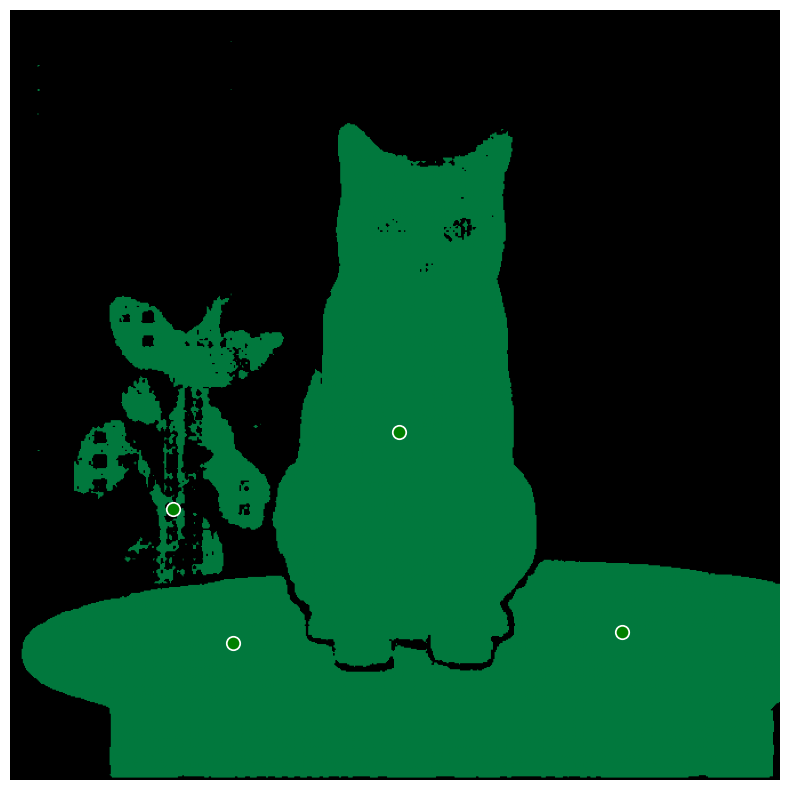

In [ ]:
f, o = process_image(Image.open("meow.png").convert('RGB'), "point to the cat")